In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

warnings.filterwarnings('ignore')

data = pd.read_csv("/Users/Cristian/Documents/EPN/Maestría en Computación/OneDrive - Escuela Politécnica Nacional/2022-B/Tesis/Dataset/20221215_151443_clustering.csv")
#data = pd.read_csv("F:/EPN/Maestría en Computación/OneDrive - Escuela Politécnica Nacional/2022-B/Tesis/Dataset/20221215_151443_clustering.csv")

df = data.loc[:, ['steering_angle', 'speed', 'rpm', 'throttle_position', 'engine_temperature', 'system_voltage', 'barometric_pressure',
    'distance_travelled', 'latitude', 'longitude', 'heart_rate', 'accidents_onsite', 'risk_level']]

le = LabelEncoder()
df['risk_level']= le.fit_transform(df['risk_level'])

n = len(pd.unique(df['risk_level']))

X = df.iloc[:,0:12]
Y = df.iloc[:,-1:]

undersample = NearMiss(version = 1, n_neighbors = 4)
X_res, Y_res = undersample.fit_resample(X, Y)

scaler = StandardScaler()
X = scaler.fit_transform(X_res)
Y = Y_res

In [2]:
Y = np.array(Y)

# **Hyperparameter Tuning**

In [3]:
model = GaussianProcessClassifier()

param_grid = {'kernel': [1*RBF()], 'max_iter_predict':[10, 20, 50, 100]}
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv = 5)
grid = grid_search.fit(X, Y.flatten())

print(
	"Best parameters are {} \nScore: {}%".format(
		grid.best_params_, grid.best_score_)
)

Best parameters are {'kernel': 1**2 * RBF(length_scale=1), 'max_iter_predict': 20} 
Score: 0.7916666666666666%


# **GPC-RBF Implementation**

In [4]:
rbf = 1 ** 2 * RBF(length_scale=1)
gpc_rbf_model = GaussianProcessClassifier(kernel = rbf, max_iter_predict = 20)

# **Cross Validation**

In [5]:
num_folds = 5
X = np.array(X)
Y = np.array(Y)

# Define per-fold score containers
acc_per_fold = []
specifity_per_fold = []
sensivity_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits = num_folds, shuffle = True)

------------------------------------------------------------------------
Training for fold 1 ...

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96        94
     Class 1       0.83      0.86      0.84       101
     Class 2       0.93      0.86      0.90        96
     Class 3       0.88      0.88      0.88        93

    accuracy                           0.90       384
   macro avg       0.90      0.90      0.90       384
weighted avg       0.90      0.90      0.90       384


Score for fold 1: - Accuracy: 0.8958333333333334 - Specifity: 0.9651300899471033 - Sensivity: 0.8966033265775102


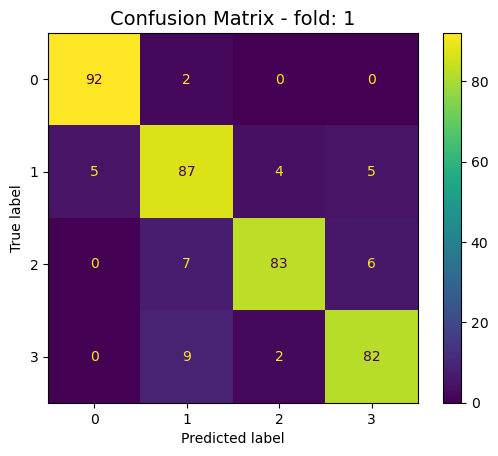

------------------------------------------------------------------------
Training for fold 2 ...

              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98        97
     Class 1       0.83      0.89      0.86        87
     Class 2       0.89      0.91      0.90        95
     Class 3       0.91      0.86      0.88       105

    accuracy                           0.90       384
   macro avg       0.90      0.90      0.90       384
weighted avg       0.91      0.90      0.90       384


Score for fold 2: - Accuracy: 0.9036458333333334 - Specifity: 0.9680808193293254 - Sensivity: 0.9041339128126039


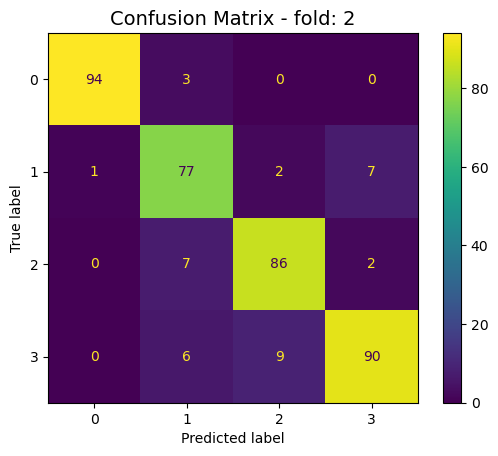

------------------------------------------------------------------------
Training for fold 3 ...

              precision    recall  f1-score   support

     Class 0       0.96      0.93      0.94        94
     Class 1       0.86      0.87      0.87        94
     Class 2       0.90      0.96      0.93        92
     Class 3       0.92      0.88      0.90       104

    accuracy                           0.91       384
   macro avg       0.91      0.91      0.91       384
weighted avg       0.91      0.91      0.91       384


Score for fold 3: - Accuracy: 0.9088541666666666 - Specifity: 0.9696403266077334 - Sensivity: 0.9097523660428378


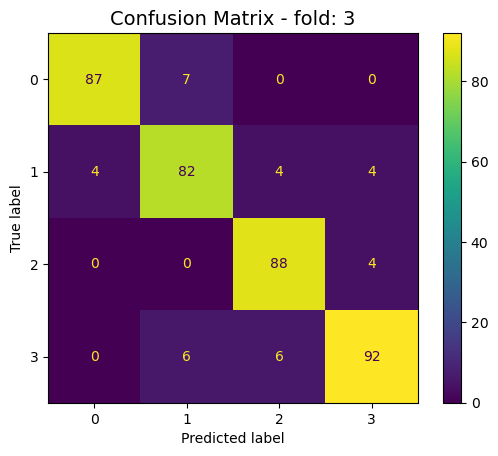

------------------------------------------------------------------------
Training for fold 4 ...

              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.96        94
     Class 1       0.92      0.85      0.88       102
     Class 2       0.91      0.87      0.89       101
     Class 3       0.87      0.97      0.91        87

    accuracy                           0.91       384
   macro avg       0.91      0.91      0.91       384
weighted avg       0.91      0.91      0.91       384


Score for fold 4: - Accuracy: 0.9114583333333334 - Specifity: 0.9705662345782741 - Sensivity: 0.9144576632364372


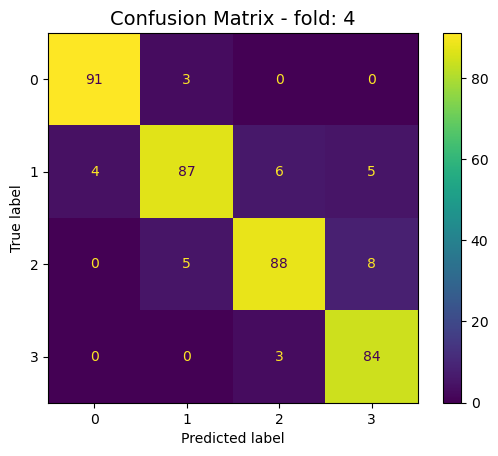

------------------------------------------------------------------------
Training for fold 5 ...

              precision    recall  f1-score   support

     Class 0       0.96      0.89      0.92       101
     Class 1       0.84      0.84      0.84        96
     Class 2       0.89      0.92      0.90        96
     Class 3       0.86      0.90      0.88        91

    accuracy                           0.89       384
   macro avg       0.89      0.89      0.89       384
weighted avg       0.89      0.89      0.89       384


Score for fold 5: - Accuracy: 0.8880208333333334 - Specifity: 0.9628048364803135 - Sensivity: 0.8881511691691146


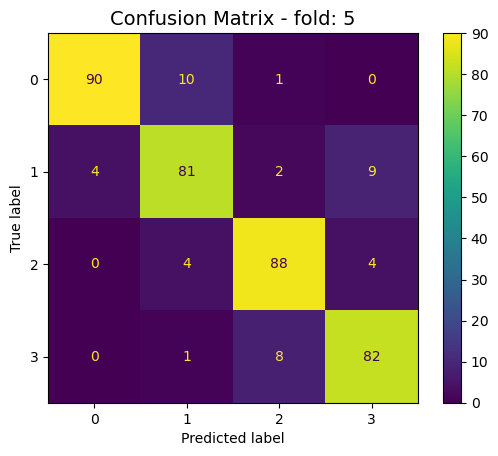

In [6]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, Y):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...\n')

    # Fit data to model
    gpc_rbf_model.fit(X[train], Y[train].flatten())
    
    # Predict the labels of test set
    y_pred = gpc_rbf_model.predict(X[test])

    target_names = ["Class {}".format(i) for i in range(n)]
    print(classification_report(Y[test], y_pred, target_names = target_names, zero_division = 0))

    # Confusion Matrix
    mcm = multilabel_confusion_matrix(Y[test], y_pred)

    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]

    specifity = np.mean(tn / (tn + fp))
    sensivity = np.mean(tp / (tp + fn))

    # Generate generalization metrics of evaluation
    scores = gpc_rbf_model.score(X[test], Y[test])
    print(f'\nScore for fold {fold_no}: - Accuracy: {scores} - Specifity: {specifity} - Sensivity: {sensivity}')

    # Plot Confusion Matrix of each fold
    ConfusionMatrixDisplay.from_predictions(Y[test], y_pred)
    plt.title(f'Confusion Matrix - fold: {fold_no}', fontsize = 14)
    plt.show()
    
    acc_per_fold.append(scores)
    specifity_per_fold.append(specifity)
    sensivity_per_fold.append(sensivity)

    # Increase fold number
    fold_no = fold_no + 1

# **Resume Evaluation Metric scores**

In [7]:
# == Provide average scores ==
print('Resume scores per fold')
for i in range(0, num_folds):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]} - Specificity: {specifity_per_fold[i]} - Sensitivity: {sensivity_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}')
print(f'> Specificity: {np.mean(specifity_per_fold)}')
print(f'> Sensitivity: {np.mean(sensivity_per_fold)}')

Resume scores per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 0.8958333333333334 - Specificity: 0.9651300899471033 - Sensitivity: 0.8966033265775102
------------------------------------------------------------------------
> Fold 2 - Accuracy: 0.9036458333333334 - Specificity: 0.9680808193293254 - Sensitivity: 0.9041339128126039
------------------------------------------------------------------------
> Fold 3 - Accuracy: 0.9088541666666666 - Specificity: 0.9696403266077334 - Sensitivity: 0.9097523660428378
------------------------------------------------------------------------
> Fold 4 - Accuracy: 0.9114583333333334 - Specificity: 0.9705662345782741 - Sensitivity: 0.9144576632364372
------------------------------------------------------------------------
> Fold 5 - Accuracy: 0.8880208333333334 - Specificity: 0.9628048364803135 - Sensitivity: 0.8881511691691146
------------------------------------------------------------------------